# Assignment

## Importing Libraries

In [1]:
import numpy as np
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the Datasets

In [2]:
cifar_dataset_train = datasets.CIFAR10(root='./data',train=True,download=True,transform=transforms.Compose([transforms.ToTensor()]))

cifar_dataset_test = datasets.CIFAR10(root='./data',train=False,download=True,transform=transforms.Compose([transforms.ToTensor()]))

Files already downloaded and verified
Files already downloaded and verified


## Creating the training dataset

In [3]:
from torch.utils.data import DataLoader
batch_size = 100

train_iter = DataLoader(cifar_dataset_train,batch_size,shuffle=True)

In [4]:
X,y = next(iter(train_iter))

## Creating the test dataset

In [5]:
test_iter = DataLoader(cifar_dataset_test,batch_size,shuffle=True)

In [6]:
X_test,y_test = next(iter(test_iter))

## Analysing the CIFAR-10 data

In [7]:
print(f'The dimensions of each input image is {X.size()} The number of input channels is {X.size()[1]}')
print(f'The output labels are as follows {y}')

The dimensions of each input image is torch.Size([100, 3, 32, 32]) The number of input channels is 3
The output labels are as follows tensor([3, 1, 2, 9, 0, 8, 1, 8, 9, 4, 9, 6, 0, 6, 7, 0, 3, 3, 8, 7, 3, 8, 6, 5,
        6, 8, 3, 9, 3, 2, 5, 0, 6, 1, 6, 3, 4, 0, 8, 5, 8, 1, 6, 4, 8, 8, 0, 9,
        5, 1, 4, 6, 2, 4, 9, 4, 7, 8, 7, 9, 4, 5, 9, 5, 4, 7, 4, 4, 9, 9, 4, 3,
        4, 2, 6, 9, 6, 3, 5, 2, 9, 4, 6, 6, 5, 2, 2, 4, 2, 5, 6, 4, 8, 9, 6, 1,
        6, 9, 9, 2])


## Example image

C:\Users\ifeda\AppData\Local\Temp\ipykernel_1380\354057698.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3575.)
  plt.imshow(X[0].T)


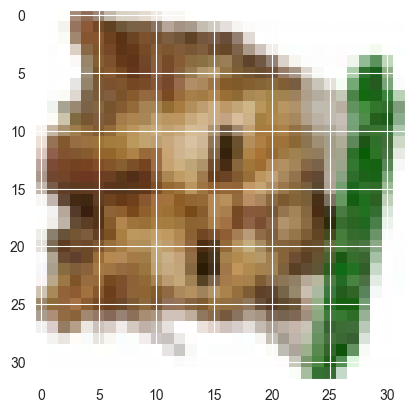

In [8]:
plt.imshow(X[0].T)

## CNN Architecture

In [54]:
class CNN(torch.nn.Module):
    def __init__(self,num_channels,num_outputs):
        super(CNN,self).__init__()
        self.num_channels = num_channels
        self.num_outputs = num_outputs

        self.batch_norm_input = torch.nn.BatchNorm2d(3)

        #Spatial/Global Pooling for input-------------------------------------------------------
        self.spatial_avg_pool1 = torch.nn.AvgPool2d(kernel_size=11,stride=2)

        # Design the base block Element---------------------------------------------------------
        #Create an input linear layer for future combination
        self.initial_block_linear = torch.nn.Sequential(
            torch.nn.Linear(in_features=36300,out_features=3),
            torch.nn.ReLU(),
            torch.nn.Dropout(0)
        )

        self.initial_block_conv = torch.nn.Sequential(
            torch.nn.Conv2d(num_channels,out_channels=10,kernel_size=3,stride=1,padding=1),
            torch.nn.BatchNorm2d(10),
            torch.nn.ReLU()

        )

        self.second_block_conv = torch.nn.Sequential(
            torch.nn.Conv2d(num_channels,out_channels=10,kernel_size=4,stride=1,padding=1),
            torch.nn.BatchNorm2d(10),
            torch.nn.ReLU()
        )

        self.third_block_conv = torch.nn.Sequential(
            torch.nn.Conv2d(num_channels,out_channels=10,kernel_size=5,stride=3,padding=1),
            torch.nn.BatchNorm2d(10),
            torch.nn.ReLU()
        )

        # Create the spatial average pooling layer for the inputs to the dense---------------------
        self.spatial_avg_pool2 = torch.nn.AvgPool1d(kernel_size = 3,stride=1)

        # Create the dense,classification block----------------------------------------------------
        # First FC linear layer
        self.initial_fc = torch.nn.Sequential(
            torch.nn.Linear(in_features=6948,out_features=500),
            torch.nn.ReLU(),
            torch.nn.Dropout(0)
        )

        # Create the final layer leading into softmax
        self.final_fc = torch.nn.Sequential(
            torch.nn.Linear(in_features=500,out_features=num_outputs),
            torch.nn.ReLU(),
            torch.nn.Dropout(0),
            torch.nn.Softmax(dim=1)
        )

    def forward(self,x):
        x = self.batch_norm_input(x)
        # Applying average pooling to down sample the image from 32 -> 24
        a = self.spatial_avg_pool1(x)

        # First Block------------------------------------------------------
        #Reshape the tensor to allow for matrix multiplication
        a = torch.flatten(a)
        a = self.initial_block_linear(a)

        # Get outputs of each convolution ->RelU layer
        o1 = self.initial_block_conv(x)
        o2 = self.second_block_conv(x)
        o3 = self.third_block_conv(x)

        O = torch.concat((o1.view(100,-1),o2.view(100,-1),o3.view(100,-1)),dim=1)

        # Prepare the outputs for the second block
        O = torch.matmul(a,O.view(3,-1))

        # Apply spatial pooling before entering the dense layer------------
        O_bn = self.spatial_avg_pool2(O.view(100,-1))

        # Move to the dense/classification block
        output = self.initial_fc(O_bn.view(100,-1))

        output = self.final_fc(output)

        return output

In [55]:
model = CNN(num_channels=3,num_outputs=10)
print(model)

CNN(
  (batch_norm_input): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (spatial_avg_pool1): AvgPool2d(kernel_size=11, stride=2, padding=0)
  (initial_block_linear): Sequential(
    (0): Linear(in_features=36300, out_features=3, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
  )
  (initial_block_conv): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (second_block_conv): Sequential(
    (0): Conv2d(3, 10, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (third_block_conv): Sequential(
    (0): Conv2d(3, 10, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (spatial_av

In [56]:
model(X).size()

torch.Size([100, 10])

## Create the metric for calculating accuracy

In [57]:
def accuracy(y_hat,y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
        cmp = (y_hat.type(y.dtype) == y)
        return float(torch.sum(cmp))

## Create the model training system

In [58]:
def train_model(model,X,y,accuracy,epochs):

    # Create the loss component
    loss = torch.nn.CrossEntropyLoss()

    # Create the optimizer term
    optimizer = torch.optim.SGD(model.parameters(), lr=0.0005,weight_decay=0.005,momentum=0.9)

    score_train = []
    l_score = []

    for epoch in range(0,epochs):
        model.train()
        y_hat = model(X)
        l = loss(y_hat,y)

        optimizer.zero_grad()

        l.backward()
        optimizer.step()

        # Training Accuracy
        score_train.append(accuracy(model(X),y)/len(y))

        # Loss graph
        l_score.append(l.item())

    return score_train,l_score

In [66]:
epochs = 70
s1,loss = train_model(model,X,y,accuracy,epochs)

In [67]:
s1

[0.69,
 0.69,
 0.69,
 0.69,
 0.69,
 0.69,
 0.69,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.71,
 0.71,
 0.71,
 0.71,
 0.72,
 0.73,
 0.74,
 0.74,
 0.74,
 0.74,
 0.74,
 0.74,
 0.74,
 0.74,
 0.74,
 0.76,
 0.76,
 0.76,
 0.76,
 0.77,
 0.77,
 0.77,
 0.78,
 0.79,
 0.8,
 0.81,
 0.81,
 0.81,
 0.81,
 0.81,
 0.81,
 0.81,
 0.81,
 0.81,
 0.81,
 0.81,
 0.81,
 0.81,
 0.81,
 0.81,
 0.81,
 0.81,
 0.81,
 0.81,
 0.81,
 0.81,
 0.81,
 0.82,
 0.82,
 0.82,
 0.82,
 0.82,
 0.82,
 0.82,
 0.82,
 0.82]

Text(0, 0.5, 'Accuracy')

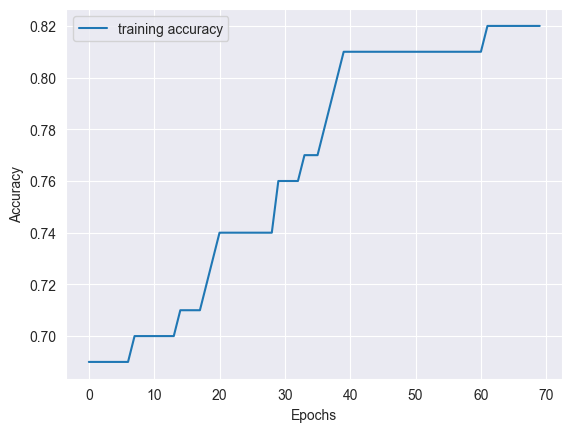

In [68]:
sns.lineplot(x=range(0,epochs),y=s1,label='training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

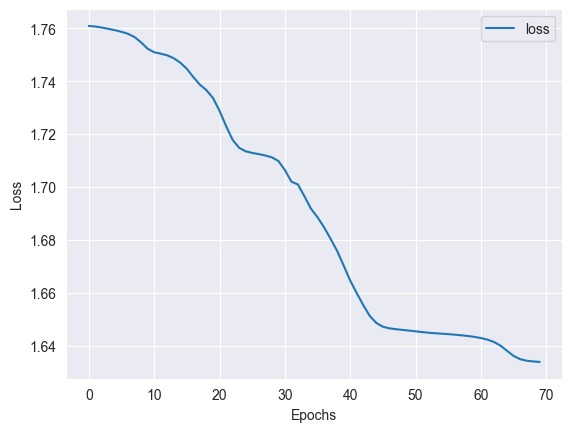

In [69]:
sns.lineplot(x=range(0,epochs),y=loss,label='loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [70]:
#model(X)

In [71]:
accuracy(model(X_test),y_test)/len(y_test)

0.09

In [72]:
y_test

tensor([3, 3, 3, 4, 4, 5, 6, 8, 9, 3, 3, 0, 0, 5, 9, 3, 3, 8, 7, 5, 2, 9, 1, 4,
        0, 1, 4, 2, 8, 4, 7, 7, 0, 1, 0, 7, 2, 7, 3, 7, 4, 5, 7, 0, 9, 6, 4, 5,
        5, 0, 4, 0, 3, 7, 2, 0, 6, 1, 1, 1, 5, 7, 3, 5, 0, 3, 4, 3, 3, 3, 2, 7,
        6, 4, 3, 1, 0, 3, 9, 4, 3, 7, 9, 8, 8, 9, 0, 1, 5, 6, 1, 6, 8, 9, 5, 1,
        8, 2, 9, 2])

In [73]:
model(X_test)[0]

tensor([0.0955, 0.0968, 0.1018, 0.1064, 0.1062, 0.1063, 0.1022, 0.0943, 0.0943,
        0.0962], grad_fn=<SelectBackward0>)